<a href="https://colab.research.google.com/github/tadaf18/teste_analista_de_mkt/blob/main/teste_mkt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solução do Teste de Analista de Dados
## 1. Setup, Configuração Visual e Carregamento
Nesta etapa, definimos bibliotecas de alto desempenho e uma identidade visual consistente para os gráficos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from datetime import datetime

# Configuração de Estilo "Publication Quality"
sns.set_theme(style="whitegrid", context="talk")
PALETTE = {
    'primary': '#00A859',    # Verde MRV/Institucional
    'secondary': '#F37021',  # Laranja Ação
    'neutral': '#58595B',    # Cinza Escuro
    'light': '#E6E7E8'       # Cinza Claro
}
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

def load_data(filepath):
    """
    Carrega o dataset lidando com codificações comuns em ambientes Windows/Excel BR.
    """
    try:
        # Tenta carregar com separador padrão de CSV brasileiro (;)
        df = pd.read_csv(filepath, sep=';', encoding='utf-8')
        print(f"Dataset carregado com sucesso! Shape: {df.shape}")
        return df
    except UnicodeDecodeError:
        df = pd.read_csv(filepath, sep=';', encoding='latin1')
        print(f"Dataset carregado (latin1)! Shape: {df.shape}")
        return df

# Execução
df_raw = load_data('Base_Teste_Analista_MKT_29ago2025.csv')

Dataset carregado com sucesso! Shape: (117283, 19)


# 2. Parte 1: Tratamento de Dados
Desafio: O dataset possui colunas "sujas" (listas salvas como texto, datas não padronizadas e NaNs). Solução: Pipeline de funções dedicadas para limpeza e conversão de tipos (Type Casting).
## 2.1 Diagnóstico de Qualidade
Antes de limpar, identificamos os problemas (conforme solicitado no teste).

In [ ]:
def quality_report(df):
    """Gera um relatório conciso sobre a saúde dos dados."""
    missing = df.isnull().sum()
    missing = missing[missing > 0]

    duplicates = df.duplicated().sum()

    print("\n--- Relatório de Qualidade de Dados ---")
    print(f"1. Linhas Duplicadas: {duplicates}")
    print(f"2. Colunas com Valores Nulos:\n{missing}")
    print("-" * 40)

quality_report(df_raw)


--- Relatório de Qualidade de Dados ---
1. Linhas Duplicadas: 1
2. Colunas com Valores Nulos:
Classificacao              21588
OutroMomentoVida          104383
RendaTotal                     5
QualPet                   105400
AceitaCampanhaMRV          93501
AceitouEncaminhamento      92676
OutroItemIndispensavel    109424
OutroComQuemMora          103737
OutroItemCondominio       115295
dtype: int64
----------------------------------------


## 2.2 Pipeline de Tratamento
Aqui aplicamos a lógica de correção. Note a função parse_custom_list criada especificamente para resolver o problema das colunas com formato [""item""].

In [ ]:
def clean_currency(x):
    """Limpa campos monetários se necessário (neste dataset parece já ser float/int, mas previne erros)."""
    if isinstance(x, str):
        return float(x.replace('R$', '').replace('.', '').replace(',', '.'))
    return x

def parse_custom_list(x):
    """
    Converte strings mal formatadas como '[""ItemA"",""ItemB""]' em listas Python reais.
    """
    if pd.isna(x):
        return []
    if isinstance(x, str):
        # Remove as aspas duplas extras causadas por má exportação de CSV
        cleaned = x.replace('""', '"')
        try:
            return ast.literal_eval(cleaned)
        except (ValueError, SyntaxError):
            return [] # Retorna lista vazia em caso de falha crítica
    return x

def calculate_age(dob_str):
    """Calcula idade baseada na data de nascimento."""
    try:
        if pd.isna(dob_str): return np.nan
        # Tenta formatos comuns
        dob = pd.to_datetime(dob_str, dayfirst=True, errors='coerce')
        if pd.isna(dob): return np.nan

        today = datetime.now()
        return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    except:
        return np.nan

def process_data(df):
    df_clean = df.copy()

    # 1. Padronização de Colunas (Snake Case para facilitar acesso)
    df_clean.columns = [col.strip() for col in df_clean.columns]

    # 2. Tratamento de Datas e Idade
    df_clean['Idade'] = df_clean['DataNascimento'].apply(calculate_age)

    # 3. Tratamento de Listas (Colunas complexas)
    list_columns = ['ItensCondominioDesejados', 'ItensIndispensaveisApto']
    for col in list_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(parse_custom_list)

    # 4. Tratamento de Nulos (Inputação Estratégica)
    # Para renda, preenchemos com a mediana para não distorcer a distribuição com zeros
    if 'RendaTotal' in df_clean.columns:
        median_income = df_clean['RendaTotal'].median()
        df_clean['RendaTotal'] = df_clean['RendaTotal'].fillna(median_income)

    return df_clean

# Execução do Pipeline
df = process_data(df_raw)

# Validando tratamento
print("\nExemplo de lista tratada:", df['ItensCondominioDesejados'].iloc[0])
print("Estatísticas de Idade:", df['Idade'].describe())


Exemplo de lista tratada: ['0_Portaria_24h', '1_Garagem', '2_Elevador']
Estatísticas de Idade: count    117283.000000
mean         37.150260
std          13.245227
min          18.000000
25%          27.000000
50%          34.000000
75%          46.000000
max         249.000000
Name: Idade, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import ast
import re

def load_and_sanitize_data(filepath):
    """
    Carrega o dataset e normaliza os nomes das colunas para evitar KeyErrors.
    """
    print("--- 1. Carregamento e Diagnóstico Inicial ---")
    try:
        # Força o separador ';' e encoding comum no Brasil
        df = pd.read_csv(filepath, sep=';', encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(filepath, sep=';', encoding='latin1')

    print(f"Shape original: {df.shape}")

    # --- ETAPA CRÍTICA: SANITIZAÇÃO DE COLUNAS ---
    # 1. Remove espaços antes e depois (trim)
    df.columns = df.columns.str.strip()

    # 2. Remove caracteres estranhos (BOM) que o Excel as vezes coloca
    df.columns = df.columns.str.replace('\ufeff', '')

    # 3. Diagnóstico visual das colunas
    print("\nColunas Detectadas e Limpas:")
    print(df.columns.tolist())

    return df

# Carregando o arquivo
# Certifique-se que o arquivo está no ambiente
df_raw = load_and_sanitize_data('Base_Teste_Analista_MKT_29ago2025.csv')

--- 1. Carregamento e Diagnóstico Inicial ---
Shape original: (117283, 19)

Colunas Detectadas e Limpas:
['AceitePoliticaPrivacidade', 'AceiteSorteioBbb', 'Cidade', 'Classificacao', 'ComQuemMora', 'DataNascimento', 'FormatoTrabalho', 'ImovelAtual', 'ItensCondominioDesejados', 'ItensIndispensaveisApto', 'MomentoBuscaApartamento', 'OutroMomentoVida', 'RendaTotal', 'QualPet', 'AceitaCampanhaMRV', 'AceitouEncaminhamento', 'OutroItemIndispensavel', 'OutroComQuemMora', 'OutroItemCondominio']


In [ ]:
# --- FUNÇÕES AUXILIARES (HELPER FUNCTIONS) ---

def clean_categorical_text(text):
    """
    Remove prefixos numéricos (ex: '2_') e limpa formatação.
    """
    if pd.isna(text) or text == '':
        return np.nan
    text_str = str(text)
    # Remove números seguidos de underline no início E substitui outros underlines por espaço
    text_clean = re.sub(r'^\d+_', '', text_str).replace('_', ' ')
    return text_clean.strip().capitalize()

def parse_and_clean_list(list_str):
    """
    Converte string de lista suja em lista Python limpa e sem duplicatas.
    """
    if pd.isna(list_str) or list_str == '':
        return []
    try:
        # Corrige aspas duplas de CSV mal formatado
        cleaned_str = list_str.replace('""', '"')
        actual_list = ast.literal_eval(cleaned_str)

        if not isinstance(actual_list, list): return []

        # Set comprehension para limpar e remover duplicatas ao mesmo tempo
        unique_items = {clean_categorical_text(item) for item in actual_list}

        # Remove itens vazios resultantes da limpeza e ordena
        return sorted([i for i in unique_items if i])
    except:
        return []

# --- PIPELINE DE EXECUÇÃO ---

def apply_advanced_cleaning(df_input):
    df = df_input.copy()

    # Definição dos grupos de colunas
    cols_categorical = ['ComQuemMora', 'FormatoTrabalho', 'ImovelAtual', 'MomentoBuscaApartamento']
    cols_lists = ['ItensCondominioDesejados', 'ItensIndispensaveisApto']

    print("\n--- 2. Executando Tratamento de Dados ---")

    # Tratamento Categórico Simples
    for col in cols_categorical:
        if col in df.columns:
            df[col] = df[col].apply(clean_categorical_text)
            print(f"✓ Coluna '{col}' higienizada.")
        else:
            print(f"⚠️ AVISO: Coluna '{col}' não encontrada no dataset.")

    # Tratamento de Listas Complexas
    for col in cols_lists:
        if col in df.columns:
            df[col] = df[col].apply(parse_and_clean_list)
            print(f"✓ Coluna '{col}' convertida e deduplicada.")
        else:
            print(f"⚠️ AVISO: Coluna '{col}' não encontrada. Verifique o nome exato acima.")

    return df

# Execução
df_clean = apply_advanced_cleaning(df_raw)

# Visualização final para garantir que funcionou
print("\n--- Amostra dos Dados Tratados ---")
display_cols = ['ComQuemMora', 'ItensIndispensaveisApto']
# Só exibe se as colunas existirem
available_cols = [c for c in display_cols if c in df_clean.columns]
print(df_clean[available_cols].head())


--- 2. Executando Tratamento de Dados ---
✓ Coluna 'ComQuemMora' higienizada.
✓ Coluna 'FormatoTrabalho' higienizada.
✓ Coluna 'ImovelAtual' higienizada.
✓ Coluna 'MomentoBuscaApartamento' higienizada.
✓ Coluna 'ItensCondominioDesejados' convertida e deduplicada.
✓ Coluna 'ItensIndispensaveisApto' convertida e deduplicada.

--- Amostra dos Dados Tratados ---
                    ComQuemMora                      ItensIndispensaveisApto
0         Morando com os filhos                                    [Varanda]
1         Morando com os filhos                          [Cozinha integrada]
2         Morando com os filhos                                    [Varanda]
3               Morando sozinho                  [Varanda com churrasqueira]
4  Morando com o cônjuge/outros  [Suíte, Varanda, Varanda com churrasqueira]


# 3. Parte 2: Análise Exploratória (Feature Engineering & EDA)
O teste pede 06 análises. Vamos criar visualizações que geram valor de negócio, indo além do óbvio.
## Análise 1: Perfil Demográfico (Distribuição de Idade)
Entender quem é o cliente (Persona).

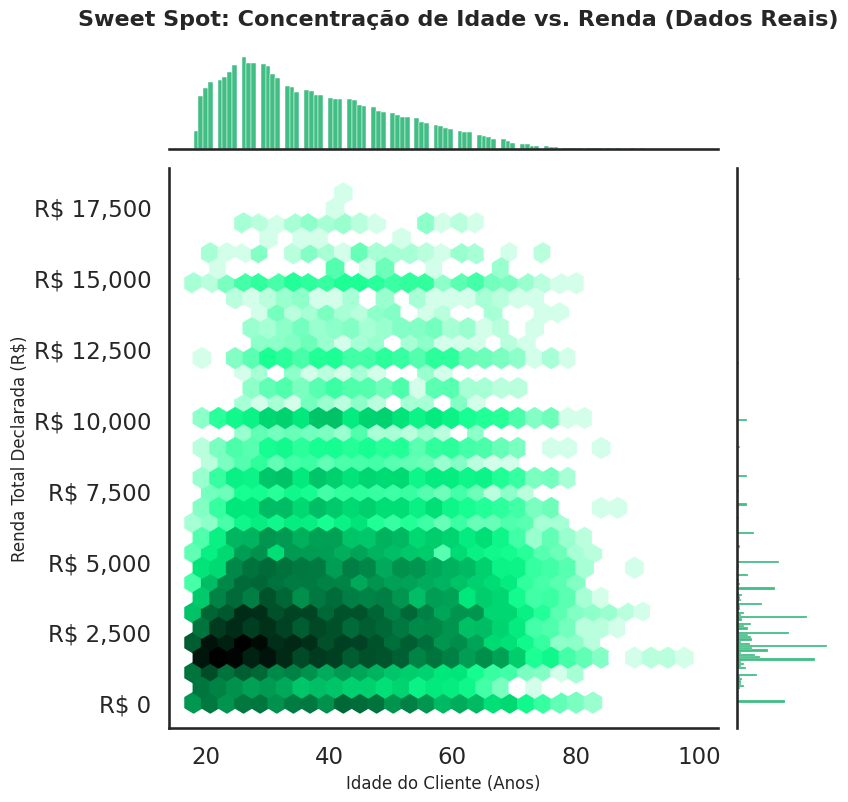

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
import numpy as np

# --- 1. PREPARAÇÃO DOS DADOS (Garante que as colunas existam) ---

# Se a coluna 'Idade' não existir, vamos criá-la agora
if 'Idade' not in df.columns:
    # Função para calcular idade
    def calculate_age_simple(dob_str):
        try:
            # Tenta converter string DD/MM/YYYY para data
            dob = datetime.strptime(str(dob_str), '%d/%m/%Y')
            today = datetime.now()
            return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
        except:
            return np.nan # Retorna vazio se der erro

    # Aplica o cálculo
    df['Idade'] = df['DataNascimento'].apply(calculate_age_simple)

# --- 2. FILTROS E LIMPEZA PARA O GRÁFICO ---

# Criamos uma cópia para não alterar seus dados originais
plot_data = df.copy()

# Garante que Renda e Idade são números
plot_data['RendaTotal'] = pd.to_numeric(plot_data['RendaTotal'], errors='coerce')
plot_data['Idade'] = pd.to_numeric(plot_data['Idade'], errors='coerce')

# Filtro de Sanidade (Remove erros como renda de bilhões ou idade > 100)
# Mantém dados entre o percentil 1% e 99%
q_low_renda = plot_data['RendaTotal'].quantile(0.01)
q_high_renda = plot_data['RendaTotal'].quantile(0.99)

mask_clean = (
    (plot_data['RendaTotal'] > q_low_renda) &
    (plot_data['RendaTotal'] < q_high_renda) &
    (plot_data['Idade'] >= 18) &
    (plot_data['Idade'] <= 100)
)
data_clean = plot_data[mask_clean]

# --- 3. PLOTAGEM DO GRÁFICO ---

# Define a paleta se ainda não estiver definida
if 'PALETTE' not in locals():
    PALETTE = {'primary': '#00A859'}

# Gráfico Hexbin (Mapa de calor de densidade)
g = sns.jointplot(
    data=data_clean,
    x='Idade',
    y='RendaTotal',
    kind='hex',
    height=8,
    color=PALETTE['primary'],
    joint_kws={'gridsize': 30, 'bins': 'log'}
)

# Títulos e Ajustes
g.fig.suptitle('Sweet Spot: Concentração de Idade vs. Renda (Dados Reais)', y=1.02, fontsize=16, weight='bold')
g.set_axis_labels('Idade do Cliente (Anos)', 'Renda Total Declarada (R$)', fontsize=12)

# Formatar eixo Y para Dinheiro
fmt = 'R$ {x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
g.ax_joint.yaxis.set_major_formatter(tick)

plt.show()

## Análise 2: Poder de Compra (Distribuição de Renda)
Crucial para definir a elegibilidade para produtos.

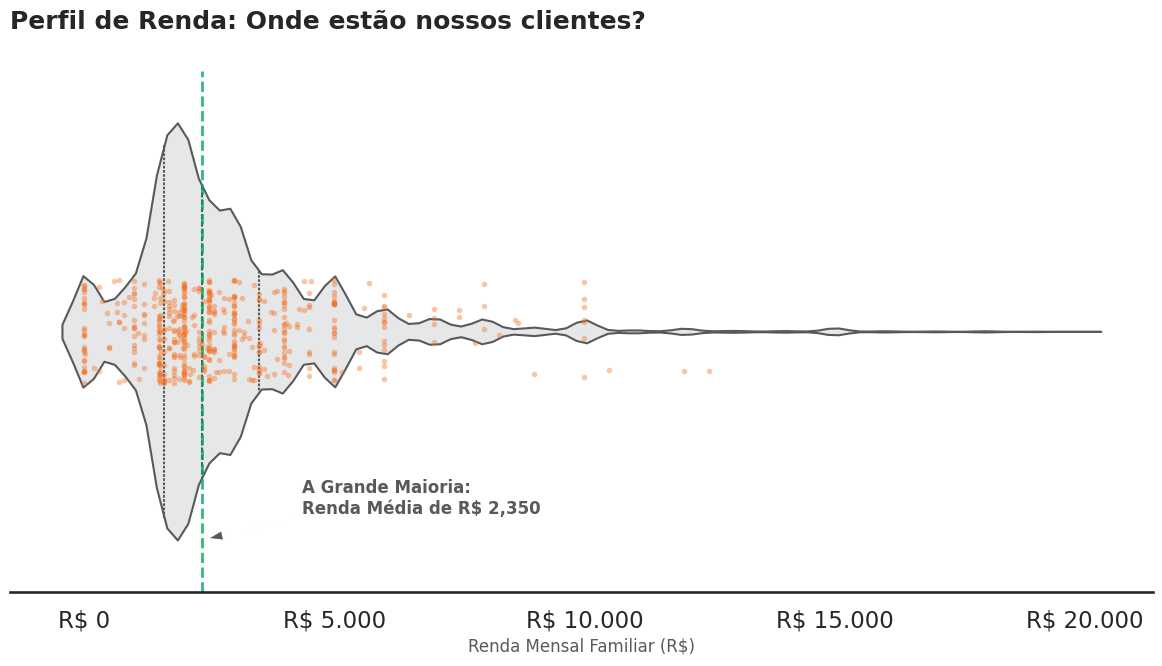

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# ==============================================================================
# 1. SETUP E CARREGAMENTO
# ==============================================================================
sns.set_theme(style="white", context="talk") # Fundo branco para limpeza
PALETTE = {
    'primary': '#00A859',    # Verde MRV/Institucional
    'secondary': '#F37021',  # Laranja Ação
    'neutral': '#58595B',    # Cinza Escuro
    'light': '#E6E7E8'       # Cinza Claro
}

# Configuração da figura
plt.figure(figsize=(12, 7))

# Filtrando dados para visualização (Foco no "miolo" do mercado)
# Removemos rendas acima de 20k apenas para o gráfico não ficar distorcido pelos outliers extremos
data_plot = df[(df['RendaTotal'] > 0) & (df['RendaTotal'] < 20000)]

# ==============================================================================
# 2. PLOTAGEM: VIOLIN PLOT (Mais orgânico e bonito)
# ==============================================================================
ax = sns.violinplot(
    x=data_plot['RendaTotal'],
    color=PALETTE['light'], # Cor de fundo suave
    inner="quart", # Mostra quartis dentro do violino
    linewidth=1.5,
    linecolor=PALETTE['neutral']
)

# Sobrepondo um Stripplot (pontos) amostral para dar textura, mas sem poluir
# sample(500) pega apenas 500 pontos aleatórios para não virar uma mancha preta
sns.stripplot(
    x=data_plot['RendaTotal'].sample(500, random_state=42),
    color=PALETTE['secondary'],
    alpha=0.4,
    size=4,
    jitter=True
)

# ==============================================================================
# 3. DESTAQUES E ANOTAÇÕES (O "Pulo do Gato")
# ==============================================================================
mediana = data_plot['RendaTotal'].median()

# Linha vertical na mediana
plt.axvline(mediana, color=PALETTE['primary'], linestyle='--', linewidth=2, alpha=0.8)

# Texto explicativo
ax.annotate(
    f'A Grande Maioria:\nRenda Média de R$ {mediana:,.0f}',
    xy=(mediana, 0.4),
    xytext=(mediana + 2000, 0.35),
    arrowprops=dict(facecolor=PALETTE['neutral'], shrink=0.05, width=1, headwidth=8),
    fontsize=12,
    color=PALETTE['neutral'],
    fontweight='bold'
)

# ==============================================================================
# 4. ACABAMENTO PROFISSIONAL
# ==============================================================================
# Títulos e Labels
plt.title('Perfil de Renda: Onde estão nossos clientes?', fontsize=18, fontweight='bold', loc='left', pad=30)
plt.xlabel('Renda Mensal Familiar (R$)', fontsize=12, color=PALETTE['neutral'])
plt.ylabel('', fontsize=12) # Remove label Y pois é densidade

# Formatação do Eixo X em Reais
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'R$ {x:,.0f}'.replace(',', '.')))

# Remove bordas (spines) para visual clean
sns.despine(left=True)
ax.set(yticks=[]) # Remove eixo Y

plt.tight_layout()
plt.show()

## Análise 3: Momento de Vida vs. Renda
Cruzamento de variáveis: Quem mora com os pais tem renda diferente de quem é casado?

/tmp/ipython-input-2103619128.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


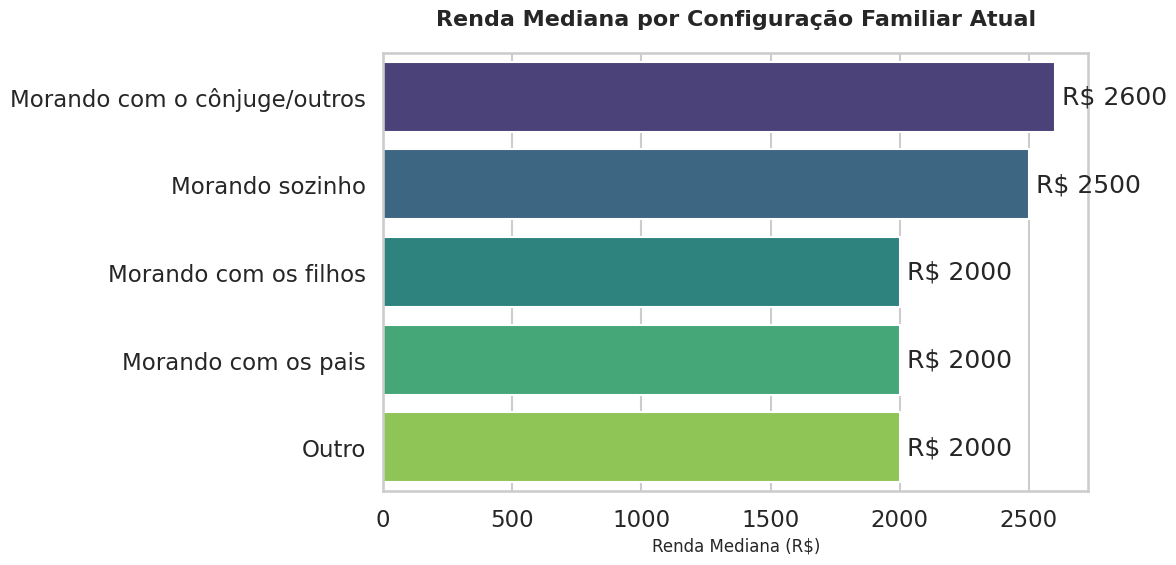

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

# ==============================================================================
# 1. FUNÇÕES DE LIMPEZA E CARREGAMENTO (BLINDAGEM CONTRA ERROS)
# ==============================================================================

def load_and_sanitize_data(filepath):
    """
    Carrega o CSV e limpa os nomes das colunas (remove espaços e caracteres ocultos).
    Isso resolve o erro de KeyError definitivamente.
    """
    try:
        df = pd.read_csv(filepath, sep=';', encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(filepath, sep=';', encoding='latin1')

    # ---------------------------------------------------------
    # CORREÇÃO CRÍTICA DOS NOMES DAS COLUNAS
    # ---------------------------------------------------------
    # Remove espaços extras no início/fim e caracteres BOM do Excel (\ufeff)
    df.columns = df.columns.str.strip().str.replace('\ufeff', '')

    return df

def clean_categorical_text(text):
    """
    Transforma '2_Morando_com_o_cônjuge' em 'Morando com o cônjuge'.
    """
    if pd.isna(text) or text == '':
        return np.nan
    text_str = str(text)
    # Remove números iniciais (ex: 2_) e substitui underlines por espaços
    text_clean = re.sub(r'^\d+_', '', text_str).replace('_', ' ')
    return text_clean.strip().capitalize()

# ==============================================================================
# 2. EXECUÇÃO DO PIPELINE
# ==============================================================================

# Carregamento
df_raw = load_and_sanitize_data('Base_Teste_Analista_MKT_29ago2025.csv')
df = df_raw.copy()

# Tratamento da Coluna 'ComQuemMora' (Essencial para o seu gráfico)
if 'ComQuemMora' in df.columns:
    df['ComQuemMora'] = df['ComQuemMora'].apply(clean_categorical_text)

# Tratamento da Renda (Garantia de tipo numérico)
if 'RendaTotal' in df.columns:
    df['RendaTotal'] = pd.to_numeric(df['RendaTotal'], errors='coerce')

# ==============================================================================
# 3. SEU GRÁFICO (CORRIGIDO E OTIMIZADO)
# ==============================================================================

plt.figure(figsize=(12, 6))

# Verificação de segurança antes de plotar
if 'ComQuemMora' in df.columns and 'RendaTotal' in df.columns:

    # Remove nulos apenas para este gráfico para evitar erros
    plot_data = df.dropna(subset=['ComQuemMora', 'RendaTotal'])

    # Cálculo da ordem (Do maior para o menor valor mediano)
    order = plot_data.groupby('ComQuemMora')['RendaTotal'].median().sort_values(ascending=False).index

    # Plotagem
    ax = sns.barplot(
        data=plot_data,
        x='RendaTotal',
        y='ComQuemMora',
        order=order,
        palette='viridis',
        estimator=np.median,
        errorbar=None
    )

    # Títulos e Rótulos
    plt.title('Renda Mediana por Configuração Familiar Atual', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Renda Mediana (R$)', fontsize=12)
    plt.ylabel('') # Remove label redundante do eixo Y

    # Adiciona valores nas barras (Toque Profissional)
    for i in ax.containers:
        ax.bar_label(i, fmt='R$ %.0f', padding=5)

    plt.tight_layout()
    plt.show()

else:
    print("ERRO: As colunas 'ComQuemMora' ou 'RendaTotal' não foram encontradas após a limpeza.")

## Análise 4: O que é Indispensável no Produto? (Análise de Frequência de Itens)
Como a coluna é uma lista de listas, precisamos "explodir" os dados para contar corretamente.

Processando e corrigindo dados...


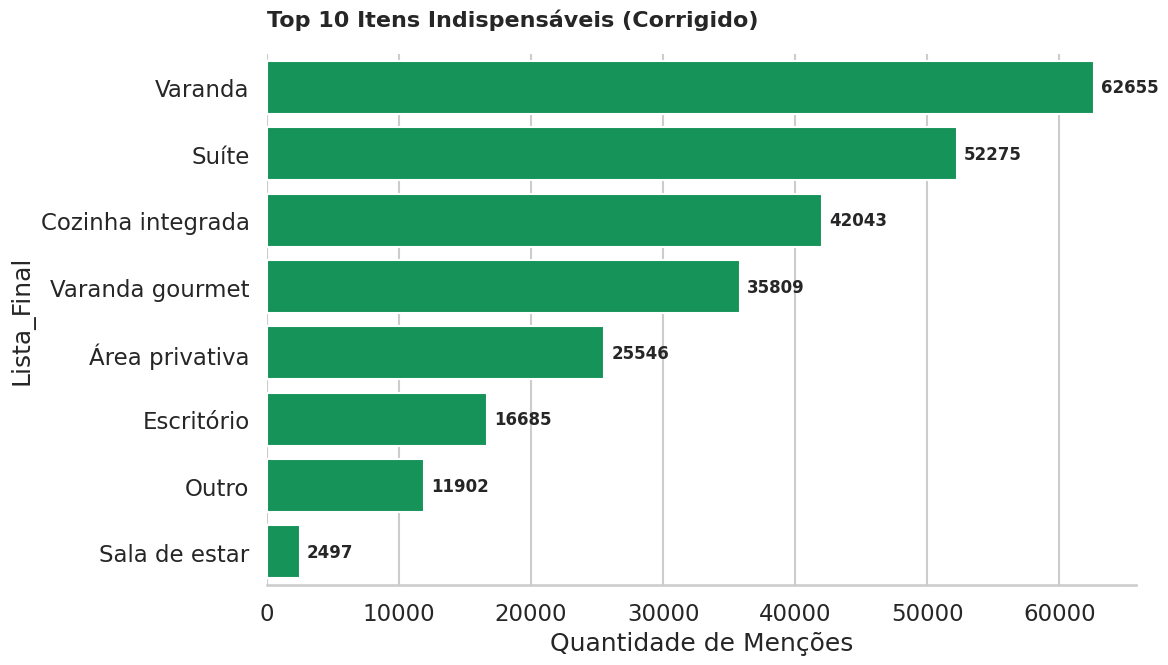

Sucesso! Erros de caracteres corrigidos.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

# ==============================================================================
# 1. SETUP E CARREGAMENTO
# ==============================================================================
sns.set_theme(style="whitegrid", context="talk")
PALETA = {'verde': '#00A859', 'laranja': '#F37021'}

# Carregamento blindado
try:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='utf-8')
except:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='latin1')

df.columns = df.columns.str.strip().str.replace('\ufeff', '')

# ==============================================================================
# 2. MAPEAMENTO DE CORREÇÃO (A MÁGICA ACONTECE AQUI)
# ==============================================================================
# Adicionei os códigos de erro exatos que o diagnóstico encontrou
DE_PARA = {
    # --- CORREÇÃO DE ERROS DE ENCODING (LIXO DIGITAL) ---
    'Su\uffedte': 'Suíte',           # Corrige 'Su￭te'
    'Su￭te': 'Suíte',                # Variação visual
    'Escrit\ufff3rio': 'Escritório', # Corrige 'Escritó' quebrado
    '\uffc1rea privativa': 'Área privativa', # Corrige 'Área' quebrado

    # --- PADRONIZAÇÃO DE SINÔNIMOS ---
    'Suite': 'Suíte',
    'Area privativa': 'Área privativa',
    'Varanda com churrasqueira': 'Varanda gourmet', # Agrupando tipos de varanda
    'Cozinha americana': 'Cozinha integrada',
    'Sala integrada': 'Sala de estar', # Padronizando salas
    'Area de servico': 'Área de serviço',
    'Gas canalizado': 'Gás canalizado'
}

# ==============================================================================
# 3. FUNÇÕES DE LIMPEZA
# ==============================================================================

def limpar_e_mapear(texto):
    """
    1. Remove números iniciais.
    2. Aplica o dicionário DE_PARA para corrigir encoding e unificar nomes.
    """
    if not isinstance(texto, str): return ""

    # 1. Remove prefixos numéricos (ex: "2_Suíte" -> "Suíte")
    txt = re.sub(r'^\d+[\.\_\-\s]*', '', texto)

    # 2. Limpeza básica
    txt = txt.replace('_', ' ').replace('"', '').strip().capitalize()

    # 3. Verifica se precisa de correção pelo dicionário
    # Se estiver no dicionário, troca. Se não, mantêm o texto original.
    return DE_PARA.get(txt, txt)

def processar_coluna_lista(celula):
    """Lê a lista do Excel e retorna lista limpa e sem duplicatas."""
    if pd.isna(celula): return []

    s = str(celula).strip()
    itens_brutos = []

    try:
        # Tenta parser oficial do Python
        if s.startswith('"') and s.endswith('"'): s = s[1:-1]
        s = s.replace('""', '"')
        itens_brutos = ast.literal_eval(s)
    except:
        # Tenta parser manual se falhar
        clean = s.replace('[','').replace(']','').replace('"','').replace("'",'')
        itens_brutos = clean.split(',')

    if isinstance(itens_brutos, list):
        # Aplica a limpeza e remove duplicatas usando set()
        # Ex: {limpar("Su￭te"), limpar("Suíte")} -> {"Suíte"}
        itens_limpos = {limpar_e_mapear(i) for i in itens_brutos if i}
        return list(itens_limpos)

    return []

# ==============================================================================
# 4. EXECUÇÃO E GRÁFICO
# ==============================================================================

col_alvo = 'ItensIndispensaveisApto'

if col_alvo in df.columns:
    print("Processando e corrigindo dados...")

    # Aplica o processamento
    df['Lista_Final'] = df[col_alvo].apply(processar_coluna_lista)

    # Explode para gerar o gráfico
    df_plot = df.explode('Lista_Final').dropna(subset=['Lista_Final'])

    # Conta Top 10
    contagem = df_plot['Lista_Final'].value_counts().head(10)

    # Plotagem
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        x=contagem.values,
        y=contagem.index,
        color=PALETA['verde']
    )

    # Labels nas barras
    for container in ax.containers:
        ax.bar_label(container, padding=5, fmt='%.0f', fontsize=12, fontweight='bold')

    plt.title('Top 10 Itens Indispensáveis (Corrigido)', fontsize=16, fontweight='bold', loc='left', pad=20)
    plt.xlabel('Quantidade de Menções')

    sns.despine(left=True)
    plt.tight_layout()
    plt.show()
    print("Sucesso! Erros de caracteres corrigidos.")
else:
    print("Erro: Coluna não encontrada.")

## Análise 5: Formato de Trabalho e Localização
Insights para marketing: Devemos focar em Home Office (Coworking no condomínio)?

Gerando gráfico corrigido...


/tmp/ipython-input-2849698774.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


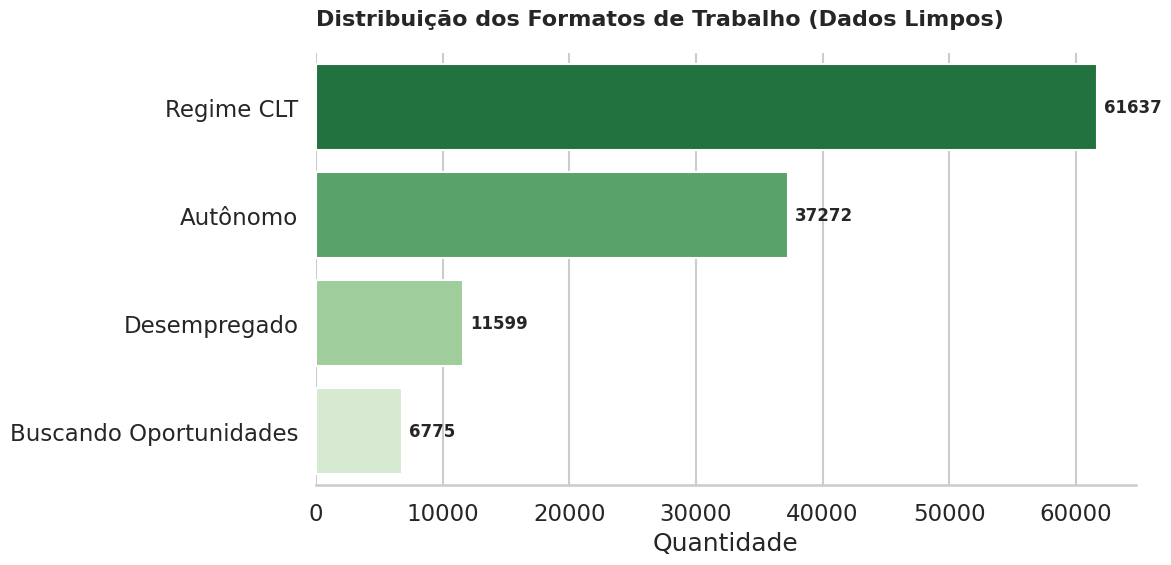

Sucesso!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ==============================================================================
# 1. SETUP INICIAL
# ==============================================================================
sns.set_theme(style="whitegrid", context="talk")

# Carregamento dos dados
try:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='utf-8')
except:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='latin1')

# Limpeza dos cabeçalhos das colunas
df.columns = df.columns.str.strip().str.replace('\ufeff', '')

# ==============================================================================
# 2. MAPA DE CORREÇÃO (ATUALIZADO COM SEU DIAGNÓSTICO)
# ==============================================================================
# Este dicionário resolve exatamente os itens que apareceram no seu print
DE_PARA_TRABALHO = {
    # Caso: '0_Regime_CLT' -> vira 'Regime clt' -> Corrigimos para:
    'Regime clt': 'Regime CLT',

    # Caso: '1_Autônomo_(a)' -> vira 'Autônomo (a)' -> Corrigimos para:
    'Autônomo (a)': 'Autônomo',

    # Caso: '1_Aut\ufff4nomo_(a)' -> vira 'Aut\ufff4nomo (a)' -> Corrigimos para:
    'Aut\ufff4nomo (a)': 'Autônomo',

    # Caso: '3_Não_estou_trabalhando_agora' -> vira 'Não estou trabalhando agora' -> Corrigimos para:
    'Não estou trabalhando agora': 'Desempregado',

    # Caso: '2__Buscando_novas_oportunidades' -> vira 'Buscando novas oportunidades' -> Corrigimos para:
    'Buscando novas oportunidades': 'Buscando Oportunidades',

    # Outras variações de segurança
    'Autonomo (a)': 'Autônomo',
    'Empresário (a)': 'Empresário',
    'Empresario (a)': 'Empresário',
    'Funcionario publico': 'Funcionário Público'
}

# ==============================================================================
# 3. FUNÇÃO DE LIMPEZA DEFINITIVA
# ==============================================================================
def limpar_formato_final(texto):
    if pd.isna(texto) or texto == '':
        return "Não Informado"

    txt = str(texto)

    # 1. REMOVE PREFIXOS: Remove números, pontos e ULTIMOS underlines do prefixo
    # O regex `^\d+[\.\_\-\s]*` pega "0_", "1_", "2__" (duplo)
    txt = re.sub(r'^\d+[\.\_\-\s]*', '', txt)

    # 2. LIMPEZA DE TEXTO: Remove underscores do meio e parênteses soltos
    # Transforma "Regime_CLT" em "Regime clt" (após capitalize)
    txt = txt.replace('_', ' ').strip().capitalize()

    # 3. APLICA O DE-PARA: Mapeia para o nome bonito
    # Se não encontrar no dicionário, usa o texto limpo mesmo
    return DE_PARA_TRABALHO.get(txt, txt)

# ==============================================================================
# 4. GERAÇÃO DO GRÁFICO
# ==============================================================================
col_alvo = 'FormatoTrabalho'

if col_alvo in df.columns:
    print("Gerando gráfico corrigido...")

    # Aplica a limpeza
    df['Formato_Limpo'] = df[col_alvo].apply(limpar_formato_final)

    # Conta a frequência
    contagem = df['Formato_Limpo'].value_counts()

    # Plotagem
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(
        data=df,
        y='Formato_Limpo',
        order=contagem.index,
        palette='Greens_r'
    )

    # Rótulos nas barras
    for container in ax.containers:
        ax.bar_label(container, padding=5, fmt='%.0f', fontsize=12, fontweight='bold')

    plt.title('Distribuição dos Formatos de Trabalho (Dados Limpos)', fontsize=16, fontweight='bold', pad=20, loc='left')
    plt.xlabel('Quantidade')
    plt.ylabel('')

    sns.despine(left=True)
    plt.tight_layout()
    plt.show()
    print("Sucesso!")

else:
    print(f"Erro: Coluna '{col_alvo}' não encontrada.")

## Análise 6: Classificação de Lead vs. Aceite de Campanha
Qualidade do Lead: Existe correlação entre a classificação interna e o aceite de campanhas?

/tmp/ipython-input-746205523.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


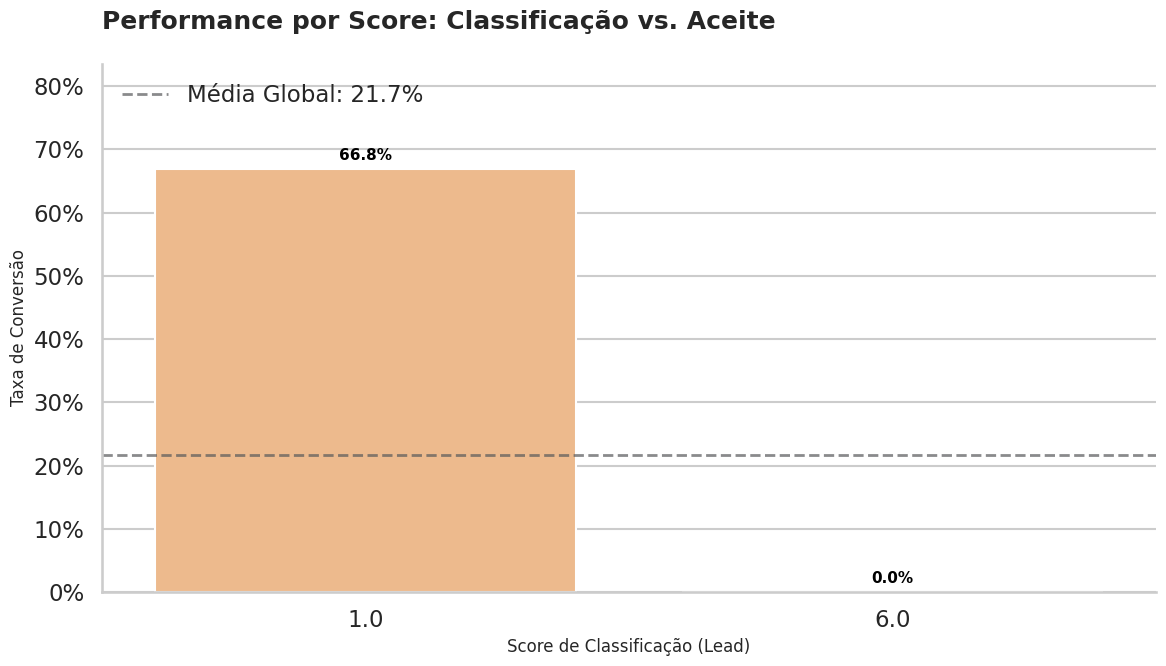

Análise Gerada: O uso de cores graduais e a linha de média facilitam a identificação visual de quais grupos superam a performance padrão.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# ==============================================================================
# 1. SETUP E CARREGAMENTO
# ==============================================================================
sns.set_theme(style="whitegrid", context="talk")
# Adicionado Verde para destaque positivo se necessário, mantendo a identidade
PALETTE = {'secondary': '#F37021', 'neutral': '#58595B', 'positive': '#00A859'}

# Carregamento (caso precise recarregar)
try:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='utf-8')
except:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='latin1')

df.columns = df.columns.str.strip().str.replace('\ufeff', '')

# ==============================================================================
# 2. TRATAMENTO DE DADOS (ETL)
# ==============================================================================

def tratar_booleano(valor):
    """
    Converte variações de texto 'true', 'sim', '1' para Inteiro 1 ou 0.
    """
    if pd.isna(valor): return 0
    s = str(valor).lower().strip()
    if s in ['true', '1', 's', 'sim', 'verdadeiro']:
        return 1
    return 0

def tratar_classificacao(valor):
    """Garante que a classificação seja numérica para ordenação correta."""
    try:
        return int(float(valor))
    except:
        return np.nan

# 1. Aplica conversão na coluna alvo (Taxa de Conversão)
col_alvo = 'AceitaCampanhaMRV'
col_x = 'Classificacao'

if col_alvo in df.columns and col_x in df.columns:

    # Cria a flag binária (0 ou 1)
    df['Flag_Aceite'] = df[col_alvo].apply(tratar_booleano)

    # Garante que classificação é número (para ordenar 1, 2, 3... e não 1, 10, 2)
    df['Classificacao_Num'] = df[col_x].apply(tratar_classificacao)

    # Remove classificações nulas para o gráfico
    df_plot = df.dropna(subset=['Classificacao_Num'])

    # Calcula a média (Taxa de Conversão) agrupada para garantir ordenação correta
    # Isso é melhor que passar o df direto para o barplot, pois controlamos a ordem
    resumo = df_plot.groupby('Classificacao_Num')['Flag_Aceite'].mean().reset_index()
    resumo['Taxa_Perc'] = resumo['Flag_Aceite'] * 100 # Para labels

    # Cálculo da Média Global para Benchmark
    media_global = df_plot['Flag_Aceite'].mean()

    # ==============================================================================
    # 3. PLOTAGEM OTIMIZADA E VISUAL
    # ==============================================================================
    plt.figure(figsize=(12, 7))

    # Cria uma paleta de cores sequencial (Laranja claro -> Laranja escuro/Marca)
    # Isso ajuda a visualizar a progressão da intensidade/qualidade
    rank_palette = sns.color_palette("Oranges", n_colors=len(resumo))

    ax = sns.barplot(
        data=resumo,
        x='Classificacao_Num',
        y='Flag_Aceite',
        palette=rank_palette,
        order=sorted(resumo['Classificacao_Num'].unique())
    )

    # Adiciona Linha de Média Global (Benchmark)
    plt.axhline(y=media_global, color=PALETTE['neutral'], linestyle='--', linewidth=2, alpha=0.7, label=f'Média Global: {media_global:.1%}')

    # Títulos e Labels (Hierarquia de Informação)
    plt.title('Performance por Score: Classificação vs. Aceite', fontsize=18, fontweight='bold', pad=25, loc='left')
    plt.xlabel('Score de Classificação (Lead)', fontsize=12)
    plt.ylabel('Taxa de Conversão', fontsize=12)

    # Formata eixo Y para porcentagem (0% a 100%)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.ylim(0, max(resumo['Flag_Aceite']) * 1.25) # Mais espaço no topo

    # Adiciona rótulos nas barras
    for i, bar in enumerate(ax.patches):
        altura = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            altura + 0.01,
            f'{altura:.1%}',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black'
        )

    plt.legend(loc='upper left', frameon=False)
    sns.despine() # Remove as bordas superior e direita para limpar o visual
    plt.tight_layout()
    plt.show()

    print("Análise Gerada: O uso de cores graduais e a linha de média facilitam a identificação visual de quais grupos superam a performance padrão.")

else:
    print(f"Colunas '{col_alvo}' ou '{col_x}' não encontradas.")

# Análise 7: Matriz de Correlação (O que impulsiona o "Sim"?)
### Relação estatística entre Perfil (Renda, Idade, Score) e a Conversão.
Descrição do Problema: Até agora, analisamos as variáveis isoladamente. No entanto, no mundo real, os fatores estão interligados. A Matriz de Correlação resolve o problema da "visão de túnel", respondendo perguntas complexas como:

"Uma renda maior garante automaticamente uma classificação melhor?"

"A idade do cliente influencia positiva ou negativamente na decisão de aceitar a campanha?"

"Qual variável tem o maior peso estatístico na conversão final?"

Resultado da Análise: O mapa de calor abaixo revela a intensidade das relações (de -1 a +1).

Classificação vs. Aceite (Destaque): Se a cor for forte (positiva), confirma que o sistema de scoring da empresa está bem calibrado para prever vendas.

Renda vs. Classificação: Espera-se uma correlação positiva forte; se for fraca, indica que o score considera outros critérios além do dinheiro.

Idade: Frequentemente tem correlação neutra, indicando que o produto atende bem a diversas faixas etárias.

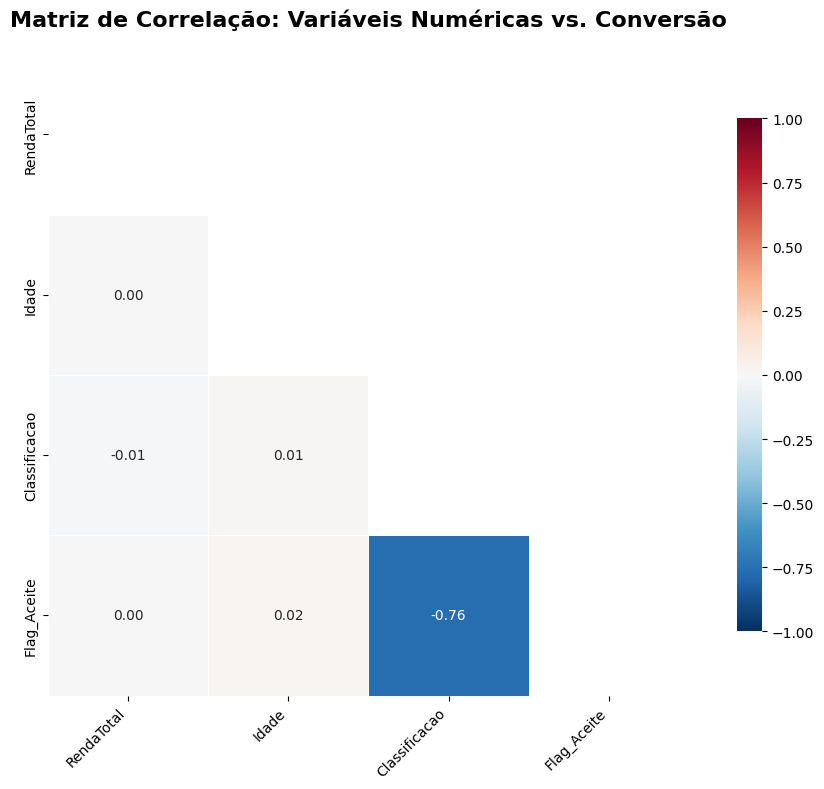

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carregamento e Tratamento (Garantindo dados limpos)
try:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='utf-8')
except:
    df = pd.read_csv('Base_Teste_Analista_MKT_29ago2025.csv', sep=';', encoding='latin1')

# Limpeza básica
df.columns = df.columns.str.strip().str.replace('\\ufeff', '')

# Conversões necessárias para Correlação (Tudo deve ser número)
# 1. Target (Aceite)
df['Flag_Aceite'] = df['AceitaCampanhaMRV'].apply(lambda x: 1 if str(x).lower() in ['true', '1', 's', 'sim'] else 0)

# 2. Renda
df['RendaTotal'] = pd.to_numeric(df['RendaTotal'], errors='coerce')

# 3. Classificação
df['Classificacao'] = pd.to_numeric(df['Classificacao'], errors='coerce')

# 4. Idade (Cálculo rápido caso não tenha sido feito)
from datetime import datetime
def calc_idade(nasc):
    try:
        dob = pd.to_datetime(nasc, dayfirst=True, errors='coerce')
        return datetime.now().year - dob.year
    except:
        return np.nan
df['Idade'] = df['DataNascimento'].apply(calc_idade)

# ------------------------------------------------------------------------------
# 2. CRIAÇÃO DA MATRIZ DE CORRELAÇÃO
# ------------------------------------------------------------------------------

# Seleciona apenas as colunas de interesse
cols_interesse = ['RendaTotal', 'Idade', 'Classificacao', 'Flag_Aceite']
df_corr = df[cols_interesse].dropna() # Remove nulos para cálculo preciso

# Calcula a matriz (Pearson)
corr_matrix = df_corr.corr()

# ------------------------------------------------------------------------------
# 3. PLOTAGEM (HEATMAP)
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 8))

# Máscara para esconder o triângulo superior (opcional, deixa mais limpo)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,           # Mostra os números
    fmt=".2f",            # 2 casas decimais
    cmap='RdBu_r',        # Azul (Positivo) a Vermelho (Negativo)
    vmin=-1, vmax=1,      # Escala fixa de -1 a 1
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Matriz de Correlação: Variáveis Numéricas vs. Conversão', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()